In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.3840,-117.1075,1.10,1.3,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.1810,-117.8180,7.30,1.4,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.3407,-149.8852,30.00,1.5,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.8703,-150.7625,111.30,2.1,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.0145,-148.7657,1.90,1.5,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30T05:22:23.246Z,37.8445,144.8923,10.00,4.3,mb,NaN,126.00,4.178,0.7000,...,2022-02-26T10:52:54.040Z,"off the east coast of Honshu, Japan",earthquake,8.0,1.8,0.137,16.0,reviewed,us,us
28331,2022-01-30T05:08:20.279Z,-30.0533,-177.1517,10.00,4.3,mb,NaN,221.00,1.034,0.6800,...,2022-02-26T10:21:50.040Z,"Kermadec Islands, New Zealand",earthquake,10.8,2.0,0.160,12.0,reviewed,us,us
28332,2022-01-30T03:50:17.124Z,54.2336,-159.7370,22.54,3.0,ml,NaN,219.00,0.604,1.0300,...,2022-02-25T00:07:12.426Z,"132 km SSE of Sand Point, Alaska",earthquake,5.2,14.1,0.088,17.0,reviewed,us,us
28333,2022-01-30T03:46:53.207Z,63.2782,-151.2517,7.40,1.0,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.2,NaN,NaN,reviewed,ak,ak


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.10,1.3,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.30,1.4,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.00,1.5,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.30,2.1,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.90,1.5,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30 05:22:23.246000+00:00,37.8445,144.8923,10.00,4.3,mb,NaN,126.00,4.178,0.7000,...,2022-02-26T10:52:54.040Z,"off the east coast of Honshu, Japan",earthquake,8.0,1.8,0.137,16.0,reviewed,us,us
28331,2022-01-30 05:08:20.279000+00:00,-30.0533,-177.1517,10.00,4.3,mb,NaN,221.00,1.034,0.6800,...,2022-02-26T10:21:50.040Z,"Kermadec Islands, New Zealand",earthquake,10.8,2.0,0.160,12.0,reviewed,us,us
28332,2022-01-30 03:50:17.124000+00:00,54.2336,-159.7370,22.54,3.0,ml,NaN,219.00,0.604,1.0300,...,2022-02-25T00:07:12.426Z,"132 km SSE of Sand Point, Alaska",earthquake,5.2,14.1,0.088,17.0,reviewed,us,us
28333,2022-01-30 03:46:53.207000+00:00,63.2782,-151.2517,7.40,1.0,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.2,NaN,NaN,reviewed,ak,ak


In [5]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [6]:
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [7]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.3840,-117.1075,1.10,1.3,1.641433e+09
1,38.1810,-117.8180,7.30,1.4,1.641433e+09
2,61.3407,-149.8852,30.00,1.5,1.641432e+09
3,62.8703,-150.7625,111.30,2.1,1.641432e+09
4,64.0145,-148.7657,1.90,1.5,1.641431e+09
...,...,...,...,...,...
28330,37.8445,144.8923,10.00,4.3,1.643520e+09
28331,-30.0533,-177.1517,10.00,4.3,1.643519e+09
28332,54.2336,-159.7370,22.54,3.0,1.643515e+09
28333,63.2782,-151.2517,7.40,1.0,1.643514e+09


In [8]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [9]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [10]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [11]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['mag'], axis = 1)

y = cleaned_df_dropped[['mag']]

In [12]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((28329, 4), (28329, 1))

In [13]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [15]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 0.3387215102940209, 	R2 score: 0.793388297081684, 	Model score: 0.793388297081684
n_estimators=3:
	Mean Squared Error: 0.30051660309548395, 	R2 score: 0.8166923409532234, 	Model score: 0.8166923409532234
n_estimators=4:
	Mean Squared Error: 0.28456163492610587, 	R2 score: 0.8264244750022871, 	Model score: 0.8264244750022871
n_estimators=5:
	Mean Squared Error: 0.27145184081249646, 	R2 score: 0.8344211235894117, 	Model score: 0.8344211235894117
n_estimators=6:
	Mean Squared Error: 0.26287703821793884, 	R2 score: 0.839651540059603, 	Model score: 0.839651540059603
n_estimators=7:
	Mean Squared Error: 0.25835440719372155, 	R2 score: 0.8424102325818866, 	Model score: 0.8424102325818866
n_estimators=8:
	Mean Squared Error: 0.2548828569330145, 	R2 score: 0.8445277919612972, 	Model score: 0.8445277919612972
n_estimators=9:
	Mean Squared Error: 0.2519677402318386, 	R2 score: 0.8463059406986264, 	Model score: 0.8463059406986264
n_estimators=10:
	Mean Squared 

In [16]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 0.3387215102940209, 	R2: 0.793388297081684, 	Model score: 0.793388297081684
n_estimators=3:
	Mean Squared Error: 0.30051660309548395, 	R2: 0.8166923409532234, 	Model score: 0.8166923409532234
n_estimators=4:
	Mean Squared Error: 0.28456163492610587, 	R2: 0.8264244750022871, 	Model score: 0.8264244750022871
n_estimators=5:
	Mean Squared Error: 0.27145184081249646, 	R2: 0.8344211235894117, 	Model score: 0.8344211235894117
n_estimators=6:
	Mean Squared Error: 0.26287703821793884, 	R2: 0.839651540059603, 	Model score: 0.839651540059603
n_estimators=7:
	Mean Squared Error: 0.25835440719372155, 	R2: 0.8424102325818866, 	Model score: 0.8424102325818866
n_estimators=8:
	Mean Squared Error: 0.2548828569330145, 	R2: 0.8445277919612972, 	Model score: 0.8445277919612972
n_estimators=9:
	Mean Squared Error: 0.2519677402318386, 	R2: 0.8463059406986264, 	Model score: 0.8463059406986264
n_estimators=10:
	Mean Squared Error: 0.2500502344277334, 	R2: 0.84747557158270

Cross-Validation

In [17]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 2833  2834  2835 ... 28326 28327 28328] | test: [   0    1    2 ... 2830 2831 2832]
Train: [    0     1     2 ... 28326 28327 28328] | test: [2833 2834 2835 ... 5663 5664 5665]
Train: [    0     1     2 ... 28326 28327 28328] | test: [5666 5667 5668 ... 8496 8497 8498]
Train: [    0     1     2 ... 28326 28327 28328] | test: [ 8499  8500  8501 ... 11329 11330 11331]
Train: [    0     1     2 ... 28326 28327 28328] | test: [11332 11333 11334 ... 14162 14163 14164]
Train: [    0     1     2 ... 28326 28327 28328] | test: [14165 14166 14167 ... 16995 16996 16997]
Train: [    0     1     2 ... 28326 28327 28328] | test: [16998 16999 17000 ... 19828 19829 19830]
Train: [    0     1     2 ... 28326 28327 28328] | test: [19831 19832 19833 ... 22661 22662 22663]
Train: [    0     1     2 ... 28326 28327 28328] | test: [22664 22665 22666 ... 25494 25495 25496]
Train: [    0     1     2 ... 25494 25495 25496] | test: [25497 25498 25499 ... 28326 28327 28328]


In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), cv=k_fold, n_jobs=-1)
    print(cv_score)

[0.79454239 0.81620423 0.86464131 0.8488487  0.84734486 0.81533188
 0.85329633 0.83043526 0.84640396 0.79305413]


In [19]:
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [20]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

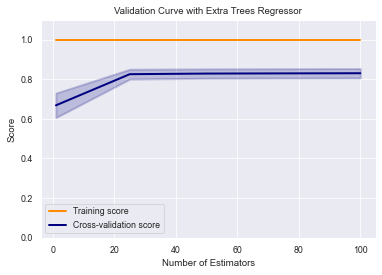

In [21]:

plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [22]:
testpred = best_model.predict(X_test)
actual_mag = y_test
testpredict = []
for item in testpred:
    testpredict.append(item)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %f' % rmse)

RMSE: 0.477776


In [23]:
print(actual_mag)

        mag
8870   0.19
3587   1.95
6356   5.50
11228  4.70
2900   1.70
...     ...
5282   0.90
13082 -0.65
21509  0.29
25047  1.22
19987  2.40

[9349 rows x 1 columns]


In [24]:
mag_pred = actual_mag
mag_pred['Predicted'] = testpredict


In [25]:
mag_pred_all = mag_pred.rename(columns={'mag': 'Actual'})
mag_pred_all

,Actual,Predicted
8870,0.19,0.8647
3587,1.95,1.5123
6356,5.50,4.3670
11228,4.70,4.9100
2900,1.70,1.7160
...,...,...
5282,0.90,1.4377
13082,-0.65,0.4936
21509,0.29,0.5442
25047,1.22,1.3661


In [26]:
mag_pred_all = mag_pred.merge(model_df, how='inner', left_index=True, right_index=True)
mag_pred_all


,mag_x,Predicted,time,latitude,longitude,depth,mag_y,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
8870,0.19,0.8647,2022-01-20 23:40:46.420000+00:00,44.371333,-110.388333,8.00,0.19,md,11.0,129.00,...,"65 km ESE of West Yellowstone, Montana",earthquake,0.41,0.62,0.183,5.0,reviewed,uu,uu,1.642722e+09
3587,1.95,1.5123,2021-12-22 13:12:47+00:00,38.230500,-112.381000,8.81,1.95,ml,23.0,185.00,...,"11 km NW of Circleville, Utah",earthquake,0.59,0.74,0.116,8.0,reviewed,uu,uu,1.640179e+09
6356,5.50,4.3670,2021-12-14 04:23:55.138000+00:00,-28.686100,-71.555500,17.79,5.50,mwr,NaN,65.00,...,"78 km W of Vallenar, Chile",earthquake,4.20,3.30,NaN,NaN,reviewed,us,guc,1.639456e+09
11228,4.70,4.9100,2022-01-13 10:01:22.570000+00:00,1.481900,122.982900,28.19,4.70,mb,NaN,57.00,...,"104 km N of Gorontalo, Indonesia",earthquake,6.50,5.90,0.147,14.0,reviewed,us,us,1.642068e+09
2900,1.70,1.7160,2021-12-24 20:15:05.365000+00:00,62.446400,-148.337100,33.50,1.70,ml,NaN,NaN,...,"72 km N of Chickaloon, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak,1.640377e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,0.90,1.4377,2021-12-17 13:30:12.501000+00:00,38.556100,-119.467700,6.70,0.90,ml,6.0,150.19,...,California-Nevada border region,earthquake,NaN,2.90,0.370,2.0,reviewed,nn,nn,1.639748e+09
13082,-0.65,0.4936,2022-01-08 09:26:27.250000+00:00,36.024333,-117.802500,0.49,-0.65,ml,7.0,112.00,...,"13km E of Coso Junction, CA",earthquake,0.26,0.94,0.119,3.0,reviewed,ci,ci,1.641634e+09
21509,0.29,0.5442,2022-02-24 17:41:27.130000+00:00,33.471333,-116.567667,10.08,0.29,ml,14.0,136.00,...,"14km SE of Anza, CA",earthquake,0.23,0.42,0.116,11.0,reviewed,ci,ci,1.645724e+09
25047,1.22,1.3661,2022-02-13 05:04:17.780000+00:00,36.570833,-121.159667,3.61,1.22,md,19.0,119.00,...,"5km NNW of Pinnacles, CA",earthquake,0.33,0.23,0.286,14.0,reviewed,nc,nc,1.644729e+09


In [27]:
mag_pred_all = mag_pred_all.rename(columns={'mag_x': 'Actual', 'mag_y': 'mag'})
mag_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
8870,0.19,0.8647,2022-01-20 23:40:46.420000+00:00,44.371333,-110.388333,8.00,0.19,md,11.0,129.00,...,"65 km ESE of West Yellowstone, Montana",earthquake,0.41,0.62,0.183,5.0,reviewed,uu,uu,1.642722e+09
3587,1.95,1.5123,2021-12-22 13:12:47+00:00,38.230500,-112.381000,8.81,1.95,ml,23.0,185.00,...,"11 km NW of Circleville, Utah",earthquake,0.59,0.74,0.116,8.0,reviewed,uu,uu,1.640179e+09
6356,5.50,4.3670,2021-12-14 04:23:55.138000+00:00,-28.686100,-71.555500,17.79,5.50,mwr,NaN,65.00,...,"78 km W of Vallenar, Chile",earthquake,4.20,3.30,NaN,NaN,reviewed,us,guc,1.639456e+09
11228,4.70,4.9100,2022-01-13 10:01:22.570000+00:00,1.481900,122.982900,28.19,4.70,mb,NaN,57.00,...,"104 km N of Gorontalo, Indonesia",earthquake,6.50,5.90,0.147,14.0,reviewed,us,us,1.642068e+09
2900,1.70,1.7160,2021-12-24 20:15:05.365000+00:00,62.446400,-148.337100,33.50,1.70,ml,NaN,NaN,...,"72 km N of Chickaloon, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak,1.640377e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,0.90,1.4377,2021-12-17 13:30:12.501000+00:00,38.556100,-119.467700,6.70,0.90,ml,6.0,150.19,...,California-Nevada border region,earthquake,NaN,2.90,0.370,2.0,reviewed,nn,nn,1.639748e+09
13082,-0.65,0.4936,2022-01-08 09:26:27.250000+00:00,36.024333,-117.802500,0.49,-0.65,ml,7.0,112.00,...,"13km E of Coso Junction, CA",earthquake,0.26,0.94,0.119,3.0,reviewed,ci,ci,1.641634e+09
21509,0.29,0.5442,2022-02-24 17:41:27.130000+00:00,33.471333,-116.567667,10.08,0.29,ml,14.0,136.00,...,"14km SE of Anza, CA",earthquake,0.23,0.42,0.116,11.0,reviewed,ci,ci,1.645724e+09
25047,1.22,1.3661,2022-02-13 05:04:17.780000+00:00,36.570833,-121.159667,3.61,1.22,md,19.0,119.00,...,"5km NNW of Pinnacles, CA",earthquake,0.33,0.23,0.286,14.0,reviewed,nc,nc,1.644729e+09


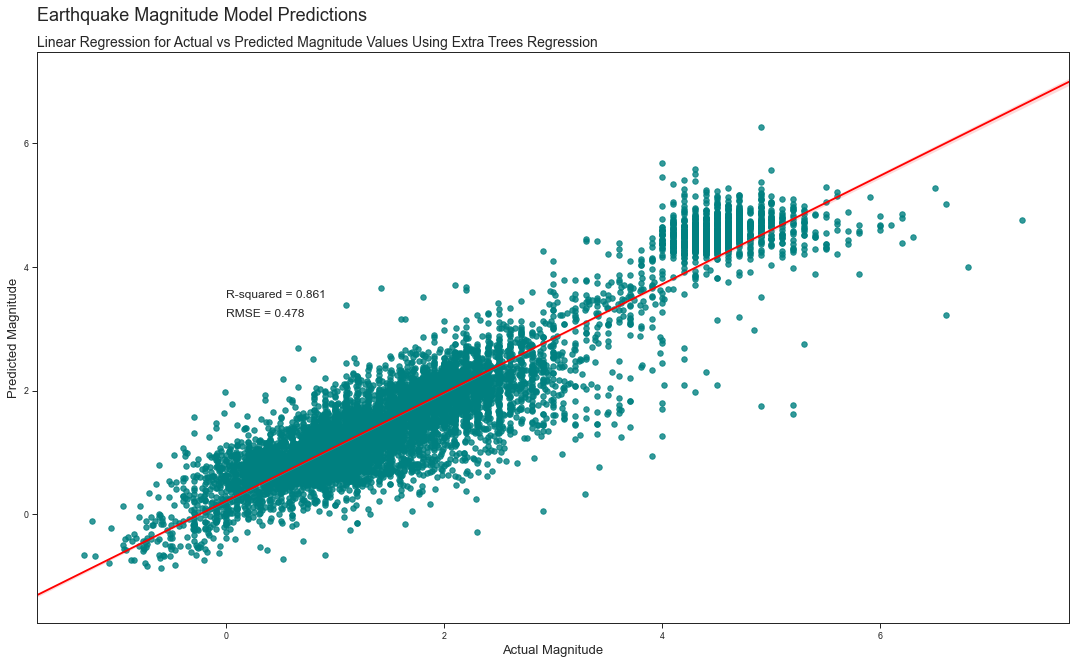

In [30]:
x = np.array(mag_pred_all['mag'])
y = np.array(testpredict)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Magnitude', fontsize=13)
plt.xlabel('Actual Magnitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Magnitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(mag_pred_all['mag'], testpredict)), (0, 3.5),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 3.2), fontsize=12)

fig.savefig('../static/images/extratrees_mag_linear_sns.png', dpi=600)
plt.show()

Test with new data from USGS

In [31]:
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-12T02:43:18.091Z,63.253700,-151.154500,7.900000,0.80,ml,NaN,NaN,NaN,0.57,...,2022-03-12T02:45:49.817Z,"42 km SE of Denali National Park, Alaska",earthquake,NaN,0.40,NaN,NaN,automatic,ak,ak
1,2022-03-12T02:24:53.720Z,36.356667,-117.965833,4.160000,1.85,ml,22.0,82.0,0.12410,0.20,...,2022-03-12T02:35:44.060Z,"9km NNE of Olancha, CA",earthquake,0.39,3.42,0.220,27.0,automatic,ci,ci
2,2022-03-12T02:00:45.806Z,-7.998200,120.725100,10.000000,4.80,mb,NaN,90.0,1.62500,0.66,...,2022-03-12T02:22:47.040Z,"73 km NNE of Ruteng, Indonesia",earthquake,2.80,1.90,0.127,21.0,reviewed,us,us
3,2022-03-12T01:49:47.220Z,38.077667,-122.232330,9.950000,2.24,md,52.0,38.0,0.02072,0.16,...,2022-03-12T02:42:19.752Z,"3km NNW of Crockett, CA",earthquake,0.24,0.47,0.120,47.0,automatic,nc,nc
4,2022-03-12T01:44:13.050Z,41.029499,-121.745499,1.110000,2.17,md,25.0,50.0,0.07271,0.08,...,2022-03-12T01:51:10.852Z,"14km E of Big Bend, CA",earthquake,0.20,1.27,0.120,14.0,automatic,nc,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2022-03-11T03:40:26.490Z,37.461167,-118.817000,3.810000,0.69,md,8.0,207.0,0.12900,0.03,...,2022-03-11T05:15:11.165Z,"16km SW of Toms Place, CA",earthquake,1.55,2.87,0.148,7.0,reviewed,nc,nc
245,2022-03-11T03:32:49.730Z,19.133833,-155.474167,30.530001,2.27,md,30.0,173.0,NaN,0.14,...,2022-03-11T03:36:02.870Z,"7 km S of Pāhala, Hawaii",earthquake,0.69,0.93,1.130,3.0,automatic,hv,hv
246,2022-03-11T03:27:19.180Z,38.182833,-111.247500,8.980000,1.57,ml,17.0,109.0,0.46810,0.11,...,2022-03-11T16:16:11.890Z,"19 km SE of Torrey, Utah",earthquake,0.44,1.67,0.227,3.0,reviewed,uu,uu
247,2022-03-11T03:25:27.783Z,61.605000,-150.402200,22.700000,1.50,ml,NaN,NaN,NaN,0.38,...,2022-03-11T03:31:35.116Z,"9 km NE of Susitna, Alaska",earthquake,NaN,0.70,NaN,NaN,automatic,ak,ak


In [32]:
test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9

In [33]:
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df

,latitude,longitude,depth,mag,Unix Time
0,63.253700,-151.154500,7.900000,0.80,1.647053e+09
1,36.356667,-117.965833,4.160000,1.85,1.647052e+09
2,-7.998200,120.725100,10.000000,4.80,1.647050e+09
3,38.077667,-122.232330,9.950000,2.24,1.647050e+09
4,41.029499,-121.745499,1.110000,2.17,1.647049e+09
...,...,...,...,...,...
244,37.461167,-118.817000,3.810000,0.69,1.646970e+09
245,19.133833,-155.474167,30.530001,2.27,1.646970e+09
246,38.182833,-111.247500,8.980000,1.57,1.646969e+09
247,61.605000,-150.402200,22.700000,1.50,1.646969e+09


In [34]:
#find if any column has NaNs
cleaned_test_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [35]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['mag'], axis = 1)

y_test_data = cleaned_test_df[['mag']]

In [36]:
pred_data_y = best_model.predict(X_test_data)


In [37]:
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data

,latitude,longitude,depth,mag,Unix Time,Predicted
0,63.253700,-151.154500,7.900000,0.80,1.647053e+09,1.4960
1,36.356667,-117.965833,4.160000,1.85,1.647052e+09,1.6466
2,-7.998200,120.725100,10.000000,4.80,1.647050e+09,4.5840
3,38.077667,-122.232330,9.950000,2.24,1.647050e+09,1.2060
4,41.029499,-121.745499,1.110000,2.17,1.647049e+09,0.9905
...,...,...,...,...,...,...
244,37.461167,-118.817000,3.810000,0.69,1.646970e+09,1.1499
245,19.133833,-155.474167,30.530001,2.27,1.646970e+09,1.8786
246,38.182833,-111.247500,8.980000,1.57,1.646969e+09,1.4917
247,61.605000,-150.402200,22.700000,1.50,1.646969e+09,1.4140


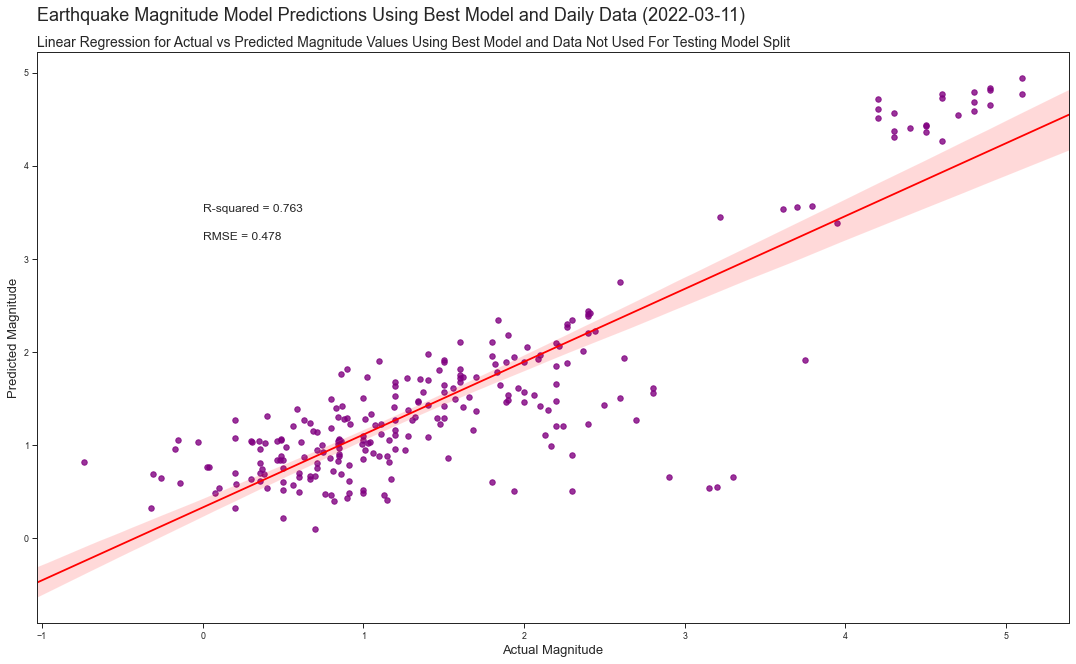

In [38]:
from datetime import date
today = date.today()

x = np.array(test_pred_data['mag'])
y = np.array(pred_data_y)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Magnitude', fontsize=13)
plt.xlabel('Actual Magnitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Magnitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(test_pred_data['mag'], pred_data_y)), (0, 3.5),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 3.2), fontsize=12)

fig.savefig('../static/images/extratrees_mag_linear_sns_daily.png', dpi=600)
plt.show()

In [ ]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
mag_pred_all.to_sql('earthquake_etrees_mag', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
mag_pred_all.to_sql('earthquake_etrees_mag', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()